In [1]:
import numpy as np
import cv2
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import util
from IPython.display import HTML
%matplotlib inline

In [2]:
# First load the distortion coefficients
dist_pickle = pickle.load(open("camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Create perspective and inverse persepective transform matrices
src = np.float32([[230, 702], [557, 477], [726, 477], [1075, 702]])
dst = np.float32([[230, 702], [230, 0], [1075, 0], [1075, 702]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

In [3]:
def process_image(image, mtx=mtx, dist=dist, M=M, Minv=Minv):
    image_undist = util.undistort(image, mtx, dist)
    
    mask_gradient = util.sobel_thresholding(image_undist)
    mask_color = util.color_thresholding(image_undist)
    mask = cv2.bitwise_and(mask_gradient, mask_color)
    
    mask = util.crop_top_image(mask)
    
    mask_warped = util.warp(mask, M)
    process_image.lane.find_lines(mask_warped)
    
    left_fit, right_fit = process_image.lane.left_fit, process_image.lane.right_fit
    
    warp_zero = np.zeros_like(mask_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ysize, xsize = mask_warped.shape
    ploty = np.linspace(0, mask_warped.shape[0]-1, mask_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] 

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image_undist, 1, newwarp, 0.3, 0)
    
    text = "Left curvature: {:.2f}m".format(process_image.lane.left_curverad)
    cv2.putText(result, text, (25, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), thickness=2)
    text = "Right curvature: {:.2f}m".format(process_image.lane.right_curverad)
    cv2.putText(result, text, (25, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), thickness=2)
    offset = process_image.lane.offset
    if offset<0:
        side = 'right'
    else:
        side = 'left'
    text = "Vehicle is {:.2f}m {} of center".format(abs(offset), side)
    cv2.putText(result, text, (25, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), thickness=2)
    return result

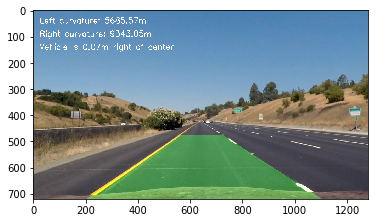

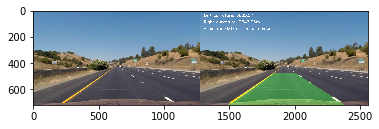

True

In [4]:
img = plt.imread('test_images/straight_lines1.jpg')
process_image.lane = util.Lane()
img_processed = process_image(img)
plt.imshow(img_processed)
plt.show()

img = util.undistort(img, mtx, dist)
img = np.concatenate((img, img_processed), axis=1)
plt.imshow(img)
plt.show()

img = img[..., ::-1]
cv2.imwrite('./output_images/.png', img)

In [5]:
def create_video(func, video_file):
    from moviepy.editor import VideoFileClip
    output_file = video_file.split('.')[0] + '_output' + '.mp4'
    clip = VideoFileClip(video_file)
    white_clip = clip.fl_image(func)
    %time white_clip.write_videofile(output_file, audio=False)
    return output_file

In [8]:
process_image.lane = util.Lane()

output_file = create_video(process_image, 'harder_challenge_video.mp4')
HTML("""
    <video width="960" height="540" controls>
      <source src="{0}">
    </video>
    """.format(output_file))

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


100%|█████████▉| 1199/1200 [04:05<00:00,  4.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

CPU times: user 4min 14s, sys: 31.4 s, total: 4min 45s
Wall time: 4min 8s
